# Cancer de próstata


Cargando bibliotecas y datos

In [1]:
# coding: utf-8
%matplotlib inline  
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import seaborn as sns
from sklearn import preprocessing
import warnings
from sklearn.model_selection import cross_val_score
warnings.filterwarnings(action='ignore')

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

SYSARMY_2020_2_GID = '12ydHqyonOaxXI9q0hJV231HHJG0bDIH3K7-rxidjpJI'

In [3]:
raw_data = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=SYSARMY_2020_2_GID))

In [4]:
raw_data.head(10)

,col,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
5,6,-1.049822,3.228826,50,-1.386294,0,-1.386294,6,0,0.765468,T
6,7,0.737164,3.473518,64,0.615186,0,-1.386294,6,0,0.765468,F
7,8,0.693147,3.539509,58,1.536867,0,-1.386294,6,0,0.854415,T
8,9,-0.776529,3.539509,47,-1.386294,0,-1.386294,6,0,1.047319,F
9,10,0.223144,3.244544,63,-1.386294,0,-1.386294,6,0,1.047319,F


In [5]:
raw_data.shape

(97, 11)

Este es un conjunto de datos bastante estándar, relativamente pequeño, con 97 observaciones y 9 variables. Aquí definiremos como objetivo y la cantidad de expresión de antígeno que está asociada con la detección de este cáncer (la columna lpsa del conjunto de datos). Las otras variables son características asociadas.

Recuperamos nuestras variables explicativas para la regresión, que colocamos en una matriz X y nuestra variable explicada Y por separado. No recuperamos la última columna del conjunto de datos, que es un valor booleano asociado con la presencia de cáncer porque no tratamos las variables discretas en este caso.

In [6]:
X_train = raw_data[['lweight','age','lbph','svi','lcp','gleason','pgg45']]
y_train = raw_data[['lpsa']]

In [7]:
def rmse_cv(model, X_train, y_train):
    rmse = np.sqrt(
        -cross_val_score(
            model, X_train, y_train, scoring="neg_mean_squared_error", cv=5
        )
    )
    return rmse.mean()

# Baseline : regresión lineal clásica

In [8]:
# Recuperamos el MSE en el conjunto de datos de prueba como baseline del error
baseline_error = rmse_cv(LinearRegression(), X_train, y_train)

print(baseline_error)

1.1326516687596861


# Ridge Regresssion

Antes que nada, escalamos los datos

<AxesSubplot:xlabel='Variables'>

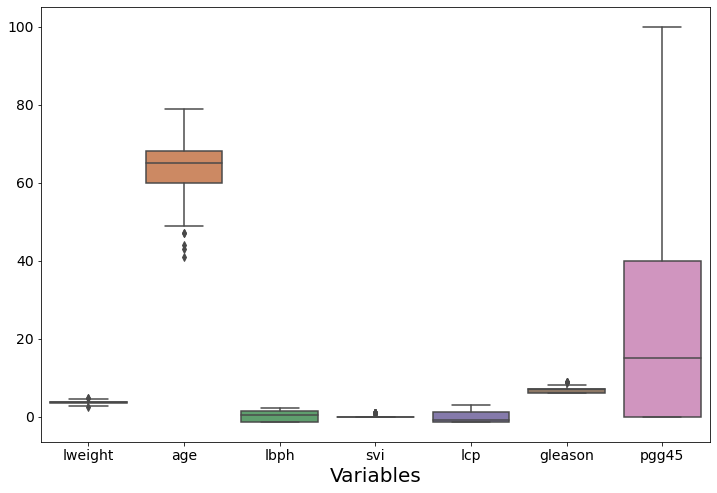

In [9]:
plt.figure(figsize=[12, 8])
plt.xlabel('Variables', fontsize=20)
sns.set_theme(style="whitegrid")
sns.boxplot(data = raw_data[['lweight','age','lbph','svi','lcp','gleason','pgg45']])

In [10]:
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
to_scale = raw_data.iloc[:,1:10]
scaler.fit(to_scale)
scaled_df = scaler.transform(to_scale)
names = to_scale.columns
scaled_prostate_df = pd.DataFrame(scaled_df, columns=names)
scaled_prostate_df['train'] = raw_data.iloc[:,10]

<AxesSubplot:xlabel='Variables'>

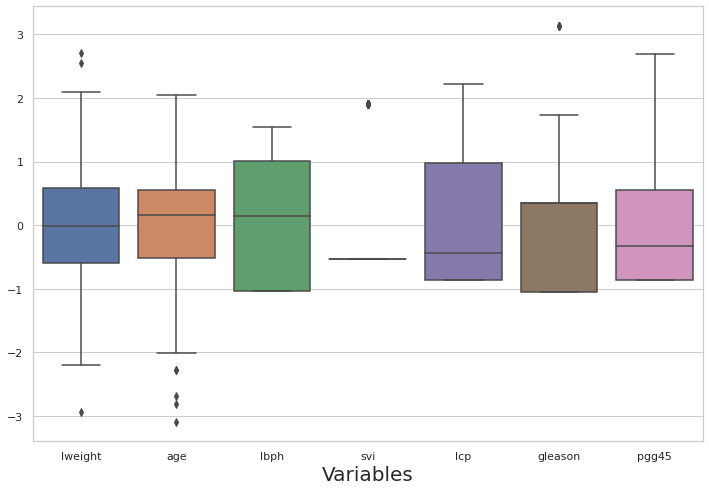

In [11]:
plt.figure(figsize=[12, 8])
plt.xlabel('Variables', fontsize=20)
sns.set_theme(style="whitegrid")
sns.boxplot(data = scaled_prostate_df[['lweight','age','lbph','svi','lcp','gleason','pgg45']])

In [12]:
X_train = scaled_prostate_df.iloc[:,:][['lweight','age','lbph','svi','lcp','gleason','pgg45']]
y_train = raw_data.iloc[:]['lpsa']

Llamamos alfa al coeficiente de regularización. 
Vamos a probar varios de ellos para determinar cuál es el más óptimo.

In [13]:
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

Ahora podemos probar todas las regresiones ridge con los diferentes valores del hiperparámetro α. Recuperamos las ponderaciones de los distintos coeficientes de la regresión asociada así como el error cuadrático.

In [14]:
ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, rmse_cv(Ridge(alpha=a), X_train, y_train)])

Puede visualizar la evolución del valor de los diferentes pesos asociados a los parámetros:

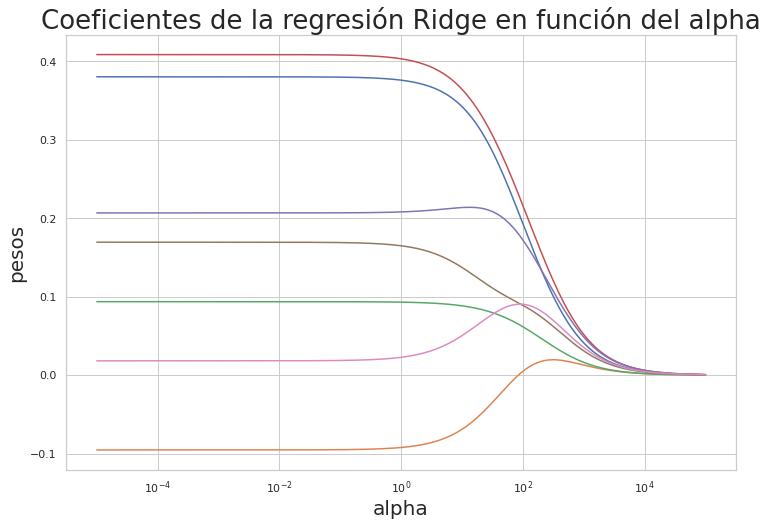

In [15]:
plt.figure(figsize=[12, 8])
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')

plt.xlabel('alpha', fontsize=20)
plt.ylabel('pesos', fontsize=20)
plt.title('Coeficientes de la regresión Ridge en función del alpha', fontsize=26)
plt.axis('tight')
plt.show()

El valor de alfa disminuye los pesos de todos los parámetros de la regresión. Ahora estudiemos el valor del error cuadrático:

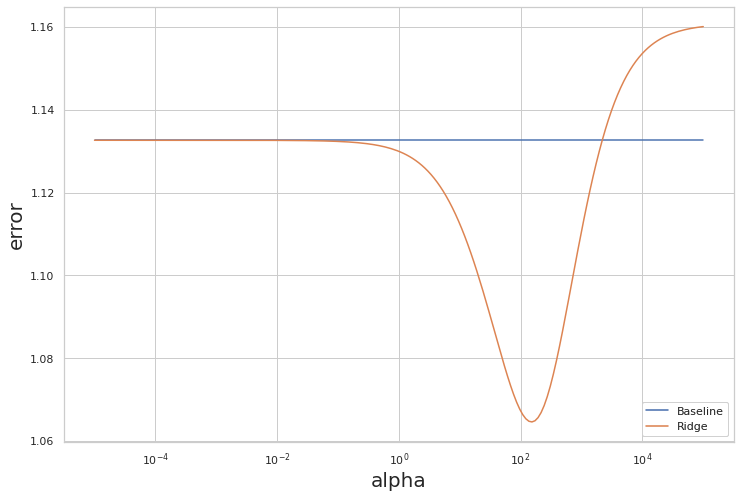

In [16]:

plt.figure(figsize=[12, 8])
ax = plt.gca()

[baseError,RidgeError] = ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('error', fontsize=20)
plt.axis('tight')
leg2 = ax.legend([baseError,RidgeError],['Baseline','Ridge'], loc='lower right')
ax.add_artist(leg2)
plt.show()

Como podemos ver, la regularización reduce el error en el conjunto de datos de prueba. Hacia alfa = 100, el mínimo parece encontrarse para la regresión Ridge. Podemos recuperar el valor mínimo:

In [17]:
min(errors)

[1.1326516687596861, 1.0645804236684773]

El primer valor corresponde al error con regresión lineal clásica y el segundo valor corresponde al error con regresión Ridge.

# Regresión Lasso

También probamos distintos valores de alpha Lasso

In [18]:
n_alphas = 300
alphas = np.logspace(-5, 1, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error,rmse_cv(linear_model.Lasso(alpha=a), X_train, y_train)])

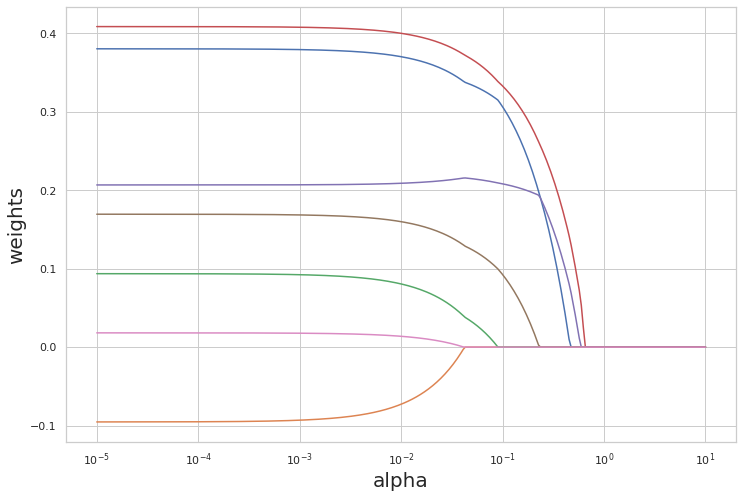

In [19]:
plt.figure(figsize=[12, 8])
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('weights', fontsize=20)
plt.axis('tight')

plt.show()

Como podemos ver, Lasso te permite eliminar variables estableciendo su peso en cero. Este es el caso si dos variables están correlacionadas. Uno será seleccionado por Lasso y el otro borrado. Esta es también su ventaja sobre una regresión Ridge que no seleccionará variables.

Ahora podemos observar el comportamiento del error.

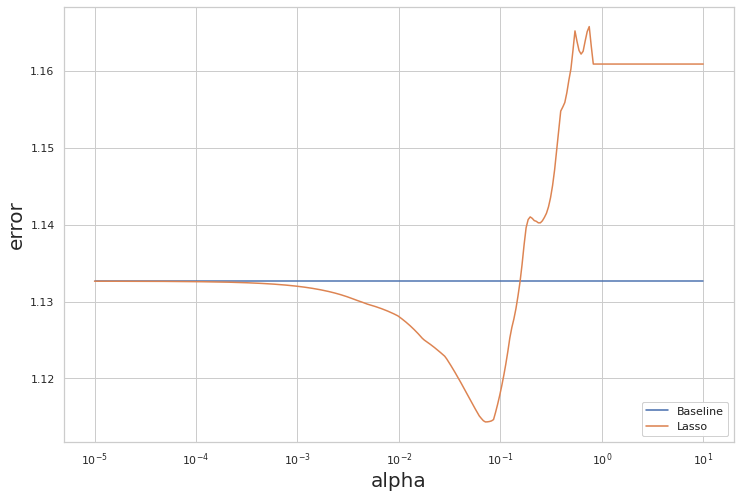

In [20]:
plt.figure(figsize=[12, 8])
ax = plt.gca()
[baseError,LassoError] = ax.plot(alphas, errors)

ax.set_xscale('log')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('error', fontsize=20)
plt.axis('tight')
leg2 = ax.legend([baseError,LassoError],['Baseline','Lasso'], loc='lower right')
ax.add_artist(leg2)
plt.show()

In [21]:
min(errors)

[1.1326516687596861, 1.1143468596808943]

En este caso Ridge funcionó mejor!

Veamos ahora ElasticNet

# Elastic Net

In [22]:
n_alphas = 300
alphas = np.logspace(-5, 1, n_alphas)


coefs = []
errors = []
for a in alphas:
    elasticNet = ElasticNet(alpha=a, l1_ratio=0.5)
    elasticNet.fit(X_train, y_train)
    coefs.append(elasticNet.coef_)
    errors.append([baseline_error,rmse_cv(ElasticNet(alpha=a, l1_ratio=0.5), X_train, y_train)])

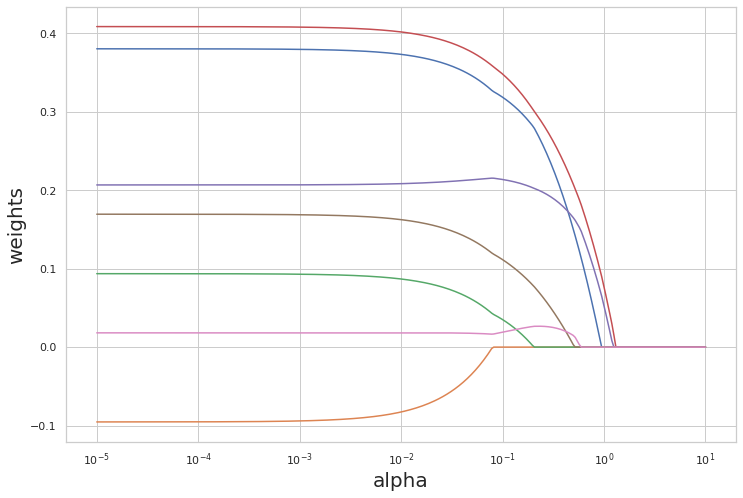

In [23]:
plt.figure(figsize=[12, 8])
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('weights', fontsize=20)
plt.axis('tight')
plt.show()

¿Por qué Elastic Net también a la larga anula (aunque mas tarde) los coeficientes?

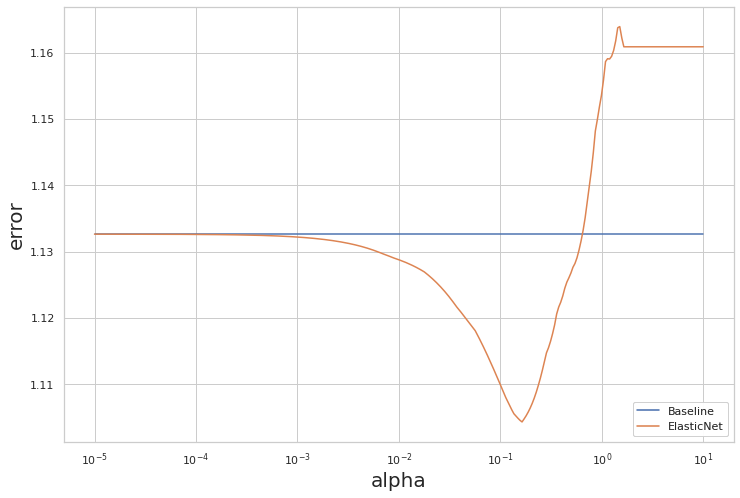

In [24]:
plt.figure(figsize=[12, 8])
ax = plt.gca()
[baseError,ElasticNetError] = ax.plot(alphas, errors)

ax.set_xscale('log')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('error', fontsize=20)
plt.axis('tight')
leg2 = ax.legend([baseError,ElasticNetError],['Baseline','ElasticNet'], loc='lower right')
ax.add_artist(leg2)
plt.show()

In [25]:
min(errors)

[1.1326516687596861, 1.1043554401795375]

Si bien Elastic Net mejora respecto a la regresión clásica, la competencia la ganó Ridge!

¿Por qué puede ser esto?